In [ ]:
%load_ext cudf.pandas # If you have an NVIDIA GPU and cudf installed

import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
import json
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

In [2]:
current_df = None

CIK_dict = pd.read_csv('../CIK_dict.csv', converters={'cik_str': str})
CIK_dict

,cik_str,ticker,title
0,0001045810,NVDA,NVIDIA CORP
1,0000789019,MSFT,MICROSOFT CORP
2,0000320193,AAPL,Apple Inc.
3,0001018724,AMZN,AMAZON COM INC
4,0001652044,GOOGL,Alphabet Inc.
...,...,...,...
10056,0002055896,FCHRF,Georg Fischer AG/ADR
10057,0001992829,SDZXF,SANDOZ GROUP AG
10058,0002053411,PCPPF,PC Partner Group Ltd/ADR
10059,0002051587,BSAAU,BEST SPAC I Acquisition Corp.


In [3]:
def get_cik(ticker):
    """
    Gets the CIK for the specified ticker
    """
    row = CIK_dict[CIK_dict['ticker'].str.upper() == ticker.upper()]
    if not row.empty:
        return row['cik_str'].values[0]
    else:
        raise ValueError(f"Ticker {ticker} not found in CIK_dict")




def get_filing_by_metrics(CIK):
    url = f'https://data.sec.gov/api/xbrl/companyfacts/CIK{CIK}.json'
    headers = {
        'User-Agent': 'jacobmgeiegr.business@gmail.com'
    }
    response = requests.get(url, headers=headers)
    data = response.json()
    return data['facts']['us-gaap']



def extract_metrics(filing_metrics):
    """
    Extracts the specified metrics from the filing
    
    Returns a dictionary of metrics with the following structure:
    {
        'metric_name': [
            {
                'entry_attributes': entry_attributes
            }
        ]
    }
    """
    metric_master = {}
    metrics = list(filing_metrics.keys())
    # print(metrics)
    for m in metrics:
        metric_data = {}
        # print(f'10-k datapoint for{m}:')
        units = filing_metrics[m]['units'] # returns a dictionary of the entries by units i.e {'USD' : '{entry},{entry},{entry},', 'USD/Share' : '{entry},{entry},{entry},'}
        for u in units: # for each unit...
            entry_data = []
            metric_entries = list(units[u]) # This is the entries for a given metric
            for entry in metric_entries:
                if entry['form'] == '10-K':
                    entry_data.append(entry)
        metric_master[m] = entry_data
    return metric_master

In [4]:
with open('NVDA_metrics.json', 'w') as f:
    json.dump(extract_metrics(get_filing_by_metrics(get_cik('NVDA'))), f)

In [5]:
def format_metrics(extracted_metrics):
    """
    Converts extracted metrics into a dataframe with the years and metrics as columns, allowing for easy plotting.
    Also renames the columns to the metric name.
    """
    
    filtered_metrics = {}
    print(extracted_metrics.items())
    for metric_name, metric_entries in extracted_metrics.items():
        # Filter out entries that have a 'frame' attribute
        filtered_entries = [
        entry for entry in metric_entries
        if 'frame' not in entry or ('frame' in entry and 'Q' not in entry['frame'] and 'q' not in entry['frame'])
        ]
        if filtered_entries:  # Only include metrics that have valid entries
            filtered_metrics[metric_name] = filtered_entries
    print(filtered_metrics.items())
    i = 0
    df_master = pd.DataFrame(columns = ['fy'])
    
    for m in filtered_metrics:
        
        metric_data = pd.DataFrame(columns = ['fy', m])
        for entry in filtered_metrics[m]:
            df = pd.DataFrame([entry])
            
            # Remove duplicate years, keep most recent. For some reason, SEC returns duplicate years and data out of order.
            
            df.rename(columns={'val': m}, inplace=True)
            
            if df.index.size >= 1:
                # print(df[['fy', m]])
                metric_data = metric_data.merge(df[['fy', m]], on=['fy', m], how='outer')
        
        metric_data.drop_duplicates(subset='fy', keep='last', inplace=True)
        # print(f'data from round: {metric_data}')
        
        
        if i == 0: # if df_master is empty
            if metric_data.index.size != 0: # if metric_data has data
                df_master = metric_data # initialize df_master with metric_data
                i += 1
            else:
                pass
        else:
            if metric_data.index.size == 0:
                pass
            else:
                df_master = metric_data.merge(df_master, how='outer', on='fy')
        
    """
    Having trouble with companies using different names for the same metric.
    For example, 'SellingAndMarketingExpense' and 'SellingGeneralAndAdministrativeExpense'
    are the same metric.
     
    """
    metric_mapping = {
        'SellingAndMarketingExpense': 'SG&A',
        'SellingGeneralAndAdministrativeExpense': 'SG&A',
        'ResearchAndDevelopmentExpense': 'R&D',
        'ResearchAndDevelopment': 'R&D'
    }
    
    df_master.rename(columns=metric_mapping, inplace=True)
        
        
        
    # print(df_master)
    return df_master

In [6]:

def format_metrics_efficient(extracted_metrics):
    """
    Converts extracted metrics into a clean, graphable DataFrame.
    This version is both efficient and accurate, correctly handling duplicate years
    by selecting the most recent filing.
    """
    # Filter out entries with 'frame' attribute to avoid aggregated/inconsistent data
    filtered_metrics = {}
    
    for metric_name, metric_entries in extracted_metrics.items():
        # Filter out entries that have a 'frame' attribute
        filtered_entries = [
        entry for entry in metric_entries
        if 'frame' not in entry or ('frame' in entry and 'Q' not in entry['frame'] and 'q' not in entry['frame'])
        ]
        if filtered_entries:  # Only include metrics that have valid entries
            filtered_metrics[metric_name] = filtered_entries
    
    # Process each metric
    all_entries = []
    for metric_name, entries in extracted_metrics.items():
        for entry in entries:
            if 'start' in entry:
            # If 'start' exists, create a new dictionary for the entry with standardized keys.
            # This flattens the data for easier processing or conversion into a DataFrame.
                all_entries.append({
                    'fy': entry['fy'],            # Fiscal year of the entry.
                    'metric': metric_name,        # The name of the financial metric.
                    'val': entry['val'],          # The value of the metric.
                    'filed': entry['filed'],      # The date the metric was filed, useful for finding the latest entry.
                    'end': entry['end'],        # The end date/period of the entry.
                    'start': entry['start']       # The start date/period of the entry.
                })
            else:
                all_entries.append({
                    'fy': entry['fy'],            # Fiscal year of the entry.
                    'metric': metric_name,        # The name of the financial metric.
                    'val': entry['val'],          # The value of the metric.
                    'filed': entry['filed'],      # The date the metric was filed, useful for finding the latest entry.
                    'end': entry['end'],        # The end date/period of the entry.
            })

    if not all_entries:
        return pd.DataFrame()

    # Create a single DataFrame from all data points at once
    df = pd.DataFrame(all_entries)

    # Convert 'filed' to datetime for correct sorting
    df['filed'] = pd.to_datetime(df['filed'])

    # Sort by filing date to ensure the latest filing comes first for each metric/year
    df.sort_values(by=['fy', 'filed', 'end', 'start'], ascending=[True, False, True, False], inplace=True)

    # Drop duplicates, keeping the first entry which is the most recent filing
    df.drop_duplicates(subset=['metric', 'fy'], keep='last', inplace=True)

    # Pivot the DataFrame to get fiscal years as the index and metrics as columns
    df_pivot = df.pivot(index='fy', columns='metric', values='val')

    # Standardize metric names
    metric_mapping = {
        'SellingAndMarketingExpense': 'SG&A',
        'SellingGeneralAndAdministrativeExpense': 'SG&A',
        'ResearchAndDevelopmentExpense': 'R&D',
        'ResearchAndDevelopment': 'R&D'
    }
    df_pivot.rename(columns=metric_mapping, inplace=True)

    # If renaming creates duplicate column names (e.g., two 'SG&A' columns),
    # group by the column names and take the first non-null value to consolidate them.
    df_pivot = df_pivot.groupby(by=df_pivot.columns, axis=1).first()

    # Reset index to make 'fy' a regular column
    df_pivot.reset_index(inplace=True)
    df_pivot.rename_axis(None, axis=1, inplace=True) # Clean up the column index name

    return df_pivot

In [270]:
nv = format_metrics(extract_metrics(get_filing_by_metrics(get_cik('NVDA'))))
nv.T

dict_items([('AcceleratedShareRepurchaseProgramAdjustment', []), ('AcceleratedShareRepurchasesFinalPricePaidPerShare', []), ('AcceleratedShareRepurchasesSettlementPaymentOrReceipt', [{'end': '2016-01-31', 'val': 587000000, 'accn': '0001045810-16-000205', 'fy': 2016, 'fp': 'FY', 'form': '10-K', 'filed': '2016-03-17', 'frame': 'CY2015Q4I'}]), ('AccountsPayableCurrent', [{'end': '2009-01-25', 'val': 218864000, 'accn': '0001045810-10-000006', 'fy': 2010, 'fp': 'FY', 'form': '10-K', 'filed': '2010-03-18', 'frame': 'CY2008Q4I'}, {'end': '2010-01-31', 'val': 344527000, 'accn': '0001045810-10-000006', 'fy': 2010, 'fp': 'FY', 'form': '10-K', 'filed': '2010-03-18'}, {'end': '2010-01-31', 'val': 344527000, 'accn': '0001045810-11-000015', 'fy': 2010, 'fp': 'FY', 'form': '10-K', 'filed': '2011-03-16', 'frame': 'CY2009Q4I'}, {'end': '2011-01-30', 'val': 286138000, 'accn': '0001045810-11-000015', 'fy': 2010, 'fp': 'FY', 'form': '10-K', 'filed': '2011-03-16'}, {'end': '2011-01-30', 'val': 286138000, '

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
fy,2010.0,2011.0,2012.0,2013.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0,2025.0
IncomeTaxesReceivableNoncurrent,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,750000000.0
ProceedsFromSaleOfEquitySecuritiesFvNi,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,171000000.0
PaymentsToAcquireEquitySecuritiesFvNi,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1.486e+09
InterestExpenseNonoperating,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,262000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AccruedProfessionalFeesCurrentAndNoncurrent,<NA>,<NA>,<NA>,<NA>,17025000.0,23000000.0,13000000.0,15000000.0,14000000.0,18000000.0,26000000.0,<NA>,<NA>,<NA>,<NA>
AccruedLiabilitiesCurrent,656544000.0,594886000.0,619795000.0,621105000.0,602807000.0,642000000.0,507000000.0,542000000.0,818000000.0,1.097e+09,1.725e+09,2.552e+09,4.12e+09,6.682e+09,1.1737e+10
AccruedIncomeTaxesNoncurrent,57590000.0,63007000.0,115267000.0,119977000.0,120961000.0,78000000.0,96000000.0,559000000.0,513000000.0,528000000.0,836000000.0,980000000.0,1.204e+09,1.361e+09,2.188e+09
AccountsReceivableNetCurrent,374963000.0,336143000.0,454252000.0,426357000.0,473637000.0,505000000.0,826000000.0,1.265e+09,1.424e+09,1.657e+09,2.429e+09,4.65e+09,3.827e+09,9.999e+09,2.3065e+10


In [7]:
nv_efficient = format_metrics_efficient(extract_metrics(get_filing_by_metrics(get_cik('RBLX'))))
nv_efficient.T

/mnt/c/JakeDev/Portfolio/project_3_financial4all/.venv/lib/python3.12/site-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return fn(*args, **kwargs)


,0,1,2,3
fy,2021.0,2022.0,2023.0,2024.0
AccountsPayableCurrent,64395000.0,71182000.0,60087000.0,42885000.0
AccountsReceivableNetCurrent,307349000.0,379353000.0,505769000.0,614838000.0
AccretionAmortizationOfDiscountsAndPremiumsInvestments,NaN,NaN,73162000.0,82835000.0
AccruedLiabilitiesCurrent,180769000.0,236006000.0,271121000.0,275754000.0
...,...,...,...,...
UnrecognizedTaxBenefitsIncreasesResultingFromPriorPeriodTaxPositions,93000.0,865000.0,16100000.0,61000.0
UnrecognizedTaxBenefitsThatWouldImpactEffectiveTaxRate,NaN,1100000.0,1400000.0,3100000.0
ValuationAllowanceDeferredTaxAssetChangeInAmount,589000000.0,195900000.0,315000000.0,329500000.0
WeightedAverageNumberOfDilutedSharesOutstanding,505858000.0,595559000.0,616445000.0,647482000.0


In [10]:
nv_efficient.T.to_csv('test.csv')

In [159]:
nv_new = nv.dropna(axis=1)
nv_new.T.to_csv('nv_new.csv')

In [271]:
nv[['fy', 'GrossProfit']]

,fy,GrossProfit
0,2010.0,1.869280e+09
1,2011.0,2.056517e+09
2,2012.0,2.226343e+09
3,2013.0,2.267763e+09
4,2015.0,2.599477e+09
5,2016.0,2.811000e+09
6,2017.0,4.063000e+09
7,2018.0,5.822000e+09
8,2019.0,7.171000e+09
9,2020.0,7.171000e+09


In [8]:
nv_efficient[['fy', 'GrossProfit']]

KeyError: "['GrossProfit'] not in index"

In [14]:
# just to make it easier to call the functions
def process_metrics(ticker: str):
    return format_metrics_efficient(extract_metrics(get_filing_by_metrics(get_cik(ticker))))

In [35]:
nv.keys()

Index(['fy', 'UnrecordedUnconditionalPurchaseObligationBalanceSheetAmount',
       'TaxCreditCarryforwardValuationAllowance',
       'DeferredTaxLiabilitiesInvestments', 'IncomeTaxesReceivableNoncurrent',
       'UnbilledContractsReceivable', 'ProceedsFromSaleOfEquitySecuritiesFvNi',
       'PaymentsToAcquireEquitySecuritiesFvNi', 'InterestExpenseNonoperating',
       'EquitySecuritiesFVNINoncurrent',
       ...
       'AccumulatedDepreciationDepletionAndAmortizationPropertyPlantAndEquipment',
       'AccruedRoyaltiesCurrent', 'AccruedRentNoncurrent',
       'AccruedRentCurrent', 'AccruedProfessionalFeesCurrentAndNoncurrent',
       'AccruedLiabilitiesCurrent', 'AccruedIncomeTaxesNoncurrent',
       'AccountsReceivableNetCurrent', 'AccountsPayableCurrent',
       'AcceleratedShareRepurchasesSettlementPaymentOrReceipt'],
      dtype='object', length=550)

In [277]:
nv_clean = nv.dropna(axis=1)
nv_clean.T.to_csv('nv_clean.csv')
# nv_clean.rename(columns={'ResearchAndDevelopmentExpense': 'Research_Development', 'SellingGeneralAndAdministrativeExpense': 'SG&A' }, inplace=True)
nv_clean.keys()
# nv_clean['ResearchandDevelopment'].T

Index(['fy', 'WeightedAverageNumberOfSharesOutstandingBasic',
       'WeightedAverageNumberOfDilutedSharesOutstanding',
       'UnrecognizedTaxBenefitsReductionsResultingFromLapseOfApplicableStatuteOfLimitations',
       'UnrecognizedTaxBenefitsIncreasesResultingFromPriorPeriodTaxPositions',
       'UnrecognizedTaxBenefitsIncreasesResultingFromCurrentPeriodTaxPositions',
       'UnrecognizedTaxBenefitsDecreasesResultingFromPriorPeriodTaxPositions',
       'StockIssuedDuringPeriodValueEmployeeStockOwnershipPlan',
       'StockholdersEquity',
       'ShareBasedCompensationArrangementByShareBasedPaymentAwardEquityInstrumentsOtherThanOptionsVestedInPeriodWeightedAverageGrantDateFairValue',
       'ShareBasedCompensationArrangementByShareBasedPaymentAwardEquityInstrumentsOtherThanOptionsVestedInPeriod',
       'ShareBasedCompensationArrangementByShareBasedPaymentAwardEquityInstrumentsOtherThanOptionsGrantsInPeriodWeightedAverageGrantDateFairValue',
       'ShareBasedCompensationArrangementB

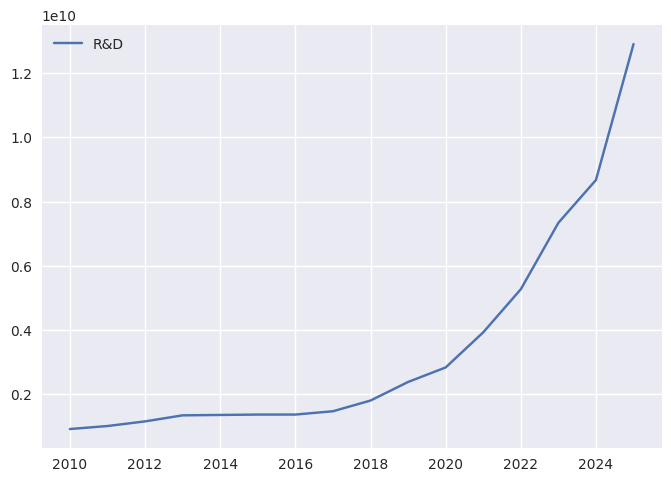

In [160]:
fig, ax = plt.subplots()
ax.plot(nv_clean['fy'], nv_clean['ResearchAndDevelopmentExpense'], label='R&D')
ax.legend()
plt.show()

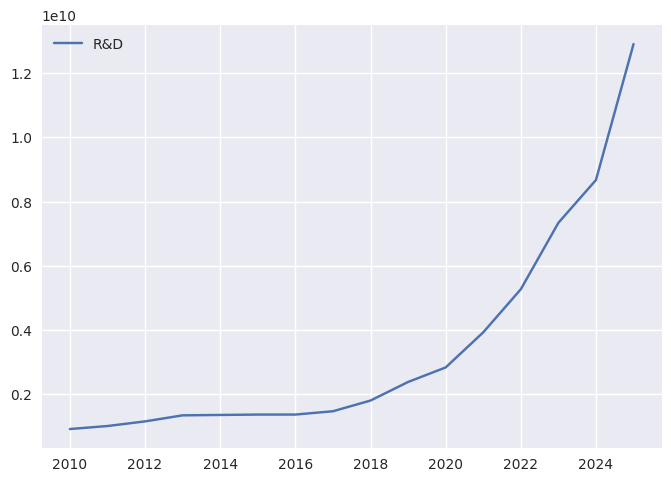

In [259]:
fig, ax = plt.subplots()
ax.plot(nv_clean['fy'], nv_clean['R&D'], label='R&D')
ax.legend()
plt.show()

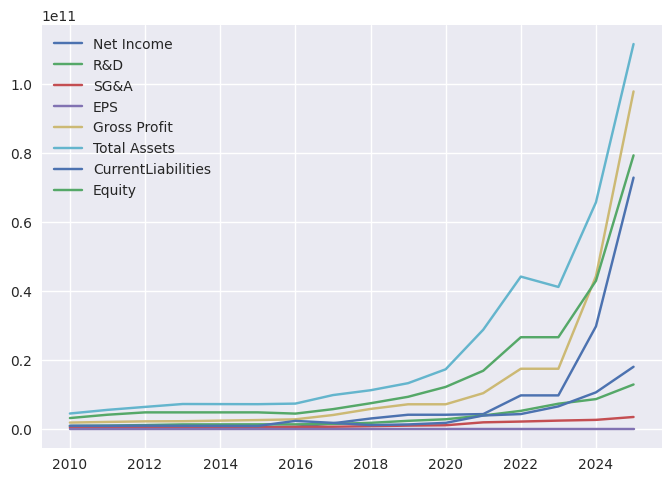

In [279]:
fig, ax = plt.subplots()
ax.plot(nv_clean['fy'], nv_clean['NetIncomeLoss'], label='Net Income')
ax.plot(nv_clean['fy'], nv_clean['R&D'], label='R&D')
ax.plot(nv_clean['fy'], nv_clean['SG&A'], label='SG&A')
ax.plot(nv_clean['fy'], nv_clean['EarningsPerShareDiluted'], label='EPS')
ax.plot(nv_clean['fy'], nv_clean['GrossProfit'], label='Gross Profit')
ax.plot(nv_clean['fy'], nv_clean['Assets'], label='Total Assets')
ax.plot(nv_clean['fy'], nv_clean['LiabilitiesCurrent'], label='CurrentLiabilities')
ax.plot(nv_clean['fy'], nv_clean['StockholdersEquity'], label='Equity')

ax.legend()
plt.show()

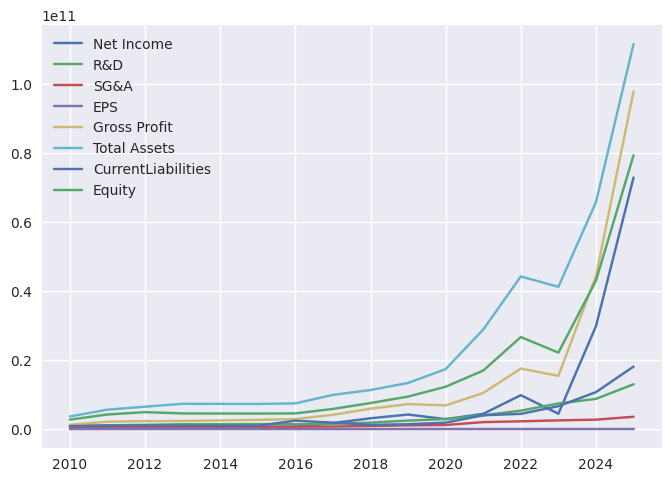

In [301]:
fig, ax = plt.subplots()
ax.plot(nv_efficient['fy'], nv_efficient['NetIncomeLoss'], label='Net Income')
ax.plot(nv_efficient['fy'], nv_efficient['R&D'], label='R&D')
ax.plot(nv_efficient['fy'], nv_efficient['SG&A'], label='SG&A')
ax.plot(nv_efficient['fy'], nv_efficient['EarningsPerShareDiluted'], label='EPS')
ax.plot(nv_efficient['fy'], nv_efficient['GrossProfit'], label='Gross Profit')
ax.plot(nv_efficient['fy'], nv_efficient['Assets'], label='Total Assets')
ax.plot(nv_efficient['fy'], nv_efficient['LiabilitiesCurrent'], label='CurrentLiabilities')
ax.plot(nv_efficient['fy'], nv_efficient['StockholdersEquity'], label='Equity')

ax.legend()
plt.show()

In [35]:
def analyze_old(ticker: str):
    """
    # Cache system to reduce API calls and speed up processing
    # This is a work in progress and will be updated as the project progresses
    
    files = []
    for entry in os.listdir('./cache/'):
        if entry.endswith('.csv'):
            files.append(entry)
    
    if ticker + '.csv' in files:
        df = pd.read_csv(ticker + '.csv')
    else:
        df = process_metrics(ticker)
        df.to_csv('./cache/' + ticker + '.csv', index=False)
    """
    
    
    
    df = process_metrics(ticker)
    df.to_csv(ticker + '.csv', index=False)
    
    
    fig, ax = plt.subplots()
    ax.plot(df['fy'], df['NetIncomeLoss'], label='Net Income')
    ax.plot(df['fy'], df['R&D'], label='R&D')
    ax.plot(df['fy'], df['SG&A'], label='SG&A')
    ax.plot(df['fy'], df['EarningsPerShareDiluted'], label='EPS')
    ax.plot(df['fy'], df['GrossProfit'], label='Gross Profit')
    ax.plot(df['fy'], df['Assets'], label='Total Assets')
    ax.plot(df['fy'], df['LiabilitiesCurrent'], label='CurrentLiabilities')
    ax.plot(df['fy'], df['StockholdersEquity'], label='Equity')
    ax.legend()
    return plt.show()

In [ ]:
# file: main.ipynb
# Section: analyze function

def analyze(ticker: str, selected_metrics: list):
    """
    # file: main.ipynb
    # Generates a Plotly figure plotting selected financial metrics against fiscal year for a given ticker.
    # This function is designed to be called from within a Jupyter Notebook environment.
    # Plotly figures provide interactive features like hover tooltips and zooming/panning.
    #
    # Parameters:
    #   ticker (str): The stock ticker symbol (e.g., 'AAPL').
    #   selected_metrics (list): A list of string names for the metrics to be plotted.
    #                            These names should correspond to column names in the DataFrame.
    #
    # Returns:
    #   plotly.graph_objects.Figure: A Plotly Figure object containing the plot.
    #                                This object can be directly displayed in a Jupyter Notebook cell.
    #                                Returns an empty figure if 'current_df' is not available or no metrics are selected.
    """
    global current_df

    # Check if a DataFrame has been loaded. If not, try to load it first.
    # This provides robustness if this cell is run independently or out of order.
    if current_df is None or current_df.empty:
        print(f"DataFrame not loaded for {ticker}. Attempting to process metrics...")
        current_df = process_metrics(ticker)
        if current_df is None or current_df.empty:
            print("Error: No data available to plot. Please ensure process_metrics loads data.")
            # Return an empty Plotly figure to avoid errors downstream if no data.
            fig = go.Figure()
            fig.update_layout(title='No Data Available')
            return fig

    # Create a new Plotly figure object.
    fig = go.Figure()

    # Check if any metrics have been selected for plotting.
    if not selected_metrics:
        fig.update_layout(
            title=f'No Metrics Selected for {ticker}',
            xaxis_title='Fiscal Year',
            yaxis_title='Value'
        )
        return fig

    # Iterate through each metric name in the 'selected_metrics' list.
    for metric in selected_metrics:
        # Ensure 'fy' (fiscal year) is not plotted against itself or if the metric column exists.
        if metric != 'fy' and metric in current_df.columns:
            # Add a scatter trace for each metric.
            # mode='lines+markers' ensures both lines and discrete data points are shown.
            # name=metric sets the legend entry.
            # hovertemplate customizes the tooltip on hover.
            fig.add_trace(go.Scatter(
                x=current_df['fy'],
                y=current_df[metric],
                mode='lines+markers', # Shows both lines and markers
                name=metric,
                hovertemplate=
                    '<b>Fiscal Year</b>: %{x}<br>' +
                    f'<b>{metric}</b>: %{{y}}<extra></extra>' # Display metric name and value on hover
            ))
        elif metric not in current_df.columns:
            # Inform the user if a selected metric is not found in the DataFrame.
            print(f"Warning: Metric '{metric}' not found in data for {ticker}. Skipping plot for this metric.")

    # Update the layout of the plot.
    fig.update_layout(
        title=f'Financial Metrics for {ticker}', # Set the title of the plot.
        xaxis_title='Fiscal Year',              # Label the x-axis.
        yaxis_title='Value',                    # Label the y-axis.
        hovermode='x unified'                   # Show combined hover info across all traces at an x-position
    )

    return fig

/mnt/c/JakeDev/Portfolio/project_3_financial4all/.venv/lib/python3.12/site-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



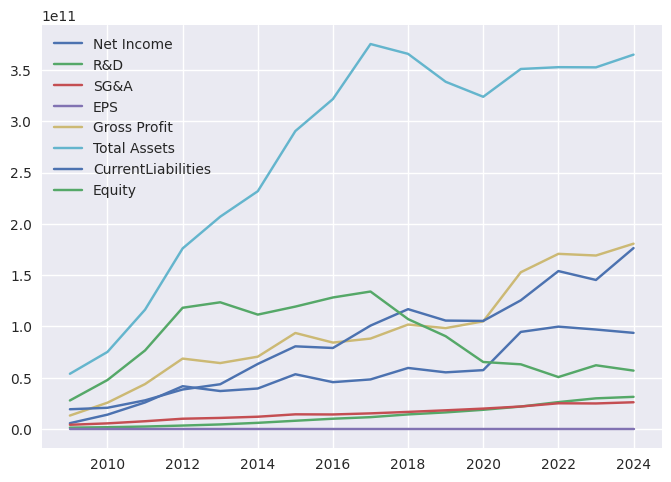

In [38]:
analyze_old('AAPL')

/mnt/c/JakeDev/Portfolio/project_3_financial4all/.venv/lib/python3.12/site-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



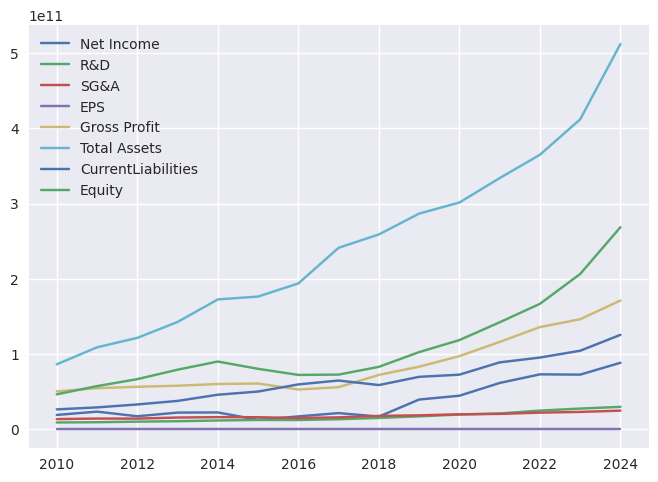

In [39]:
analyze_old('MSFT')
#ms = process_metrics('MSFT')
#ms.T.to_csv('ms.csv')

/mnt/c/JakeDev/Portfolio/project_3_financial4all/.venv/lib/python3.12/site-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



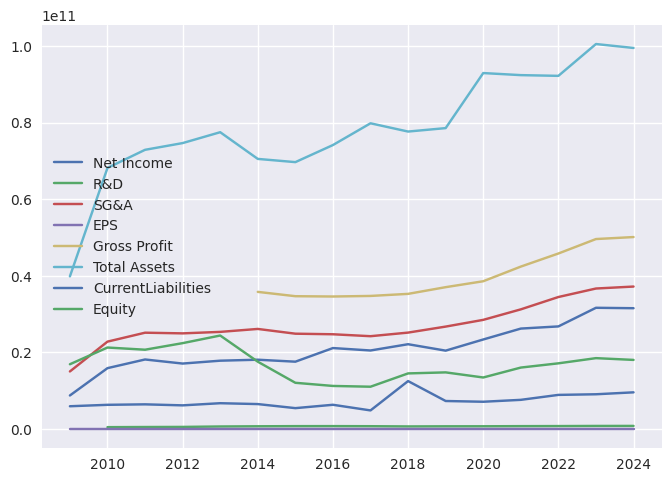

In [40]:
analyze_old('PEP')

In [33]:
# Section: Interactive Plotting Interface

import ipywidgets as widgets
from IPython.display import display, clear_output



# --- Global Variables for UI state and data ---
# Global output widgets to control where print statements and plots appear.
# This prevents outputs from cluttering the main cell.
status_output = widgets.Output() # For messages like "Loading..."
plot_output = widgets.Output()   # For displaying the matplotlib plot

# Global variable to store ALL plottable metrics for the current ticker.
# This list will now store tuples of (metric_name, fill_rate) and represents
# the complete set of available metrics before any user-applied filters.
# Example: [('Assets', 0.95), ('Revenue', 0.8), ...]
_all_plottable_metrics = []
current_df = None # Global variable to store the currently loaded DataFrame

# --- Widget Definitions ---
# Create a text input widget for the user to enter the ticker symbol.
ticker_input = widgets.Text(
    value='AAPL',  # Default value for convenience
    placeholder='Enter Ticker Symbol (e.g., AAPL)',
    description='Ticker:',
    disabled=False,
    continuous_update=False # Only update when Enter is pressed or focus leaves
)

# Create a text input widget for filtering the metrics.
metric_filter_input = widgets.Text(
    value='',
    placeholder='Type to filter metrics...',
    description='Filter:',
    continuous_update=True # Update as user types (more responsive filtering)
)

# Create new checkbox widgets for additional filtering options.
# These will be disabled until data is successfully loaded.
fill_rate_checkbox = widgets.Checkbox(
    value=False,
    description='Only show metrics with >= 80% data fill',
    disabled=True # Disable initially until data is loaded
)

# Example of another general checkbox filter. You can add more as needed.
only_financial_checkbox = widgets.Checkbox(
    value=False,
    description='Only show core financial metrics (e.g., Revenue, Assets, EPS)',
    disabled=True # Disable initially until data is loaded
)

# Create a SelectMultiple widget for choosing which metrics to plot.
# It will be initially empty and populated after data is loaded.
available_metrics_selector = widgets.SelectMultiple(
    options=[],     # Options are populated dynamically
    value=[],       # Default selected values (none selected initially as per request)
    description='Select Metrics:',
    disabled=True,  # Disable initially until data is loaded
    rows=10,        # Show more options without scrolling
    layout=widgets.Layout(width='auto', height='250px') # Adjust layout for better display
)

# --- Helper Function for applying all filters ---
def _apply_all_filters():
    """
    # file: main.ipynb
    # Helper function to apply all active filters (text search, fill rate,
    # and other checkbox filters) to the comprehensive list of plottable metrics.
    # It updates the options and selected values of the available_metrics_selector.
    """
    global _all_plottable_metrics, available_metrics_selector, metric_filter_input
    global fill_rate_checkbox, only_financial_checkbox, current_df # Include new checkboxes and current_df for contextual checks

    if current_df is None or current_df.empty:
        # If no data is loaded, there are no metrics to filter.
        available_metrics_selector.options = []
        available_metrics_selector.value = []
        return

    # Start with all metrics and their fill rates.
    temp_filtered_metrics_names = []
    text_filter = metric_filter_input.value.strip().lower()

    # Iterate through the pre-calculated _all_plottable_metrics
    for metric_name, fill_rate in _all_plottable_metrics:
        # Apply text filter: skip if filter text is present but not in metric name
        if text_filter and text_filter not in metric_name.lower():
            continue

        # Apply 80% fill rate filter: skip if checkbox is checked and fill rate is below threshold
        if fill_rate_checkbox.value and fill_rate < 0.8:
            continue

        # Apply "only core financial metrics" filter (example)
        # You'll need to define what constitutes a "core financial metric" more robustly.
        # For this example, it's based on simple keyword matching.
        if only_financial_checkbox.value:
            core_financial_keywords = ['revenue', 'income', 'profit', 'asset', 'liability', 'equity', 'cash flow', 'eps', 'debt']
            is_financial = any(keyword in metric_name.lower() for keyword in core_financial_keywords)
            if not is_financial:
                continue

        # If all filters pass, add the metric name to the list of currently available options.
        temp_filtered_metrics_names.append(metric_name)

    # Preserve currently selected items that are still present in the filtered list.
    # This correctly handles the user's requirement: "it unselects metrics they previously
    # selected if not in the pool."
    current_selection = list(available_metrics_selector.value)
    new_selection = [item for item in current_selection if item in temp_filtered_metrics_names]

    # Update the SelectMultiple widget's options and selected values.
    available_metrics_selector.options = temp_filtered_metrics_names
    available_metrics_selector.value = new_selection


# --- Callback Functions ---
def on_filter_change(change):
    """
    # file: main.ipynb
    # Callback function executed when the metric_filter_input's value changes.
    # It triggers the application of all filters to update the available metrics.
    """
    _apply_all_filters() # Call the consolidated filter function

def on_checkbox_change(change):
    """
    # file: main.ipynb
    # Callback function executed when any filter checkbox's value changes.
    # It triggers the application of all filters to update the available metrics.
    """
    _apply_all_filters() # Call the consolidated filter function


def on_ticker_change(change):
    """
    # file: main.ipynb
    # Callback function executed when the ticker_input's value changes.
    # It loads new data, calculates fill rates, updates the available metrics,
    # and triggers an initial plot based on the current selections.
    """
    global current_df, _all_plottable_metrics

    with status_output:
        clear_output(wait=True) # Clear previous messages
        ticker = change['new'].strip().upper() # Get new ticker, clean it, and uppercase.

        if not ticker:
            print("Please enter a valid ticker symbol.")
            # Reset UI elements to their initial disabled/empty state
            available_metrics_selector.options = []
            available_metrics_selector.value = []
            available_metrics_selector.disabled = True
            fill_rate_checkbox.disabled = True # Disable new checkboxes
            only_financial_checkbox.disabled = True
            _all_plottable_metrics = [] # Clear the full list of metrics
            with plot_output:
                clear_output(wait=True)
            return

        print(f"Loading data for {ticker}...")
        try:
            # Call process_metrics to get the DataFrame for the new ticker.
            # Assuming process_metrics returns a pandas DataFrame.
            current_df = process_metrics(ticker)

            if current_df is None or current_df.empty:
                print(f"No data retrieved for {ticker}.")
                # Reset UI elements if no data
                available_metrics_selector.options = []
                available_metrics_selector.value = []
                available_metrics_selector.disabled = True
                fill_rate_checkbox.disabled = True
                only_financial_checkbox.disabled = True
                _all_plottable_metrics = []
                with plot_output:
                    clear_output(wait=True)
                return

            # Calculate fill rates for all plottable columns and populate _all_plottable_metrics.
            # 'fy' is typically the fiscal year and not a metric to be analyzed for fill rate in this context.
            _all_plottable_metrics = []
            for col in current_df.columns.tolist():
                if col == 'fy': # Skip the 'fy' (fiscal year) column for metric analysis
                    continue
                # Calculate fill rate: count of non-NA values divided by total number of rows.
                fill_rate = current_df[col].count() / len(current_df)
                _all_plottable_metrics.append((col, fill_rate))

            # Enable the metric selector and filter checkboxes once data is successfully loaded.
            available_metrics_selector.disabled = False
            fill_rate_checkbox.disabled = False
            only_financial_checkbox.disabled = False

            print(f"Data loaded for {ticker}. Select metrics to plot. No metrics are selected by default.")

            # Apply all filters to update the available metrics selector options based on
            # the newly loaded data and current filter settings.
            _apply_all_filters()

            # Immediately trigger the plot update with the *currently selected* metrics.
            # This ensures the plot is displayed even if no new selections are made,
            # for example, on initial load or ticker change with no default selections.
            update_plot(list(available_metrics_selector.value))

        except Exception as e:
            clear_output()
            print(f"Error loading data for {ticker}: {e}")
            # Reset states on error
            current_df = None
            available_metrics_selector.options = []
            available_metrics_selector.value = []
            available_metrics_selector.disabled = True
            fill_rate_checkbox.disabled = True
            only_financial_checkbox.disabled = True
            _all_plottable_metrics = []
            with plot_output:
                clear_output(wait=True)

def update_plot(selected_metrics):
    """
    # file: main.ipynb
    # Callback function for the interactive plot.
    # This function is triggered whenever the 'selected_metrics' (from the SelectMultiple widget) change.
    # It generates and displays a Plotly figure.
    """
    with plot_output:
        clear_output(wait=True) # Clear the previous plot to display the new one.
        if current_df is None or current_df.empty:
            print("No data loaded. Please enter a ticker above and click 'Enter' or unfocus.")
            return
        if not selected_metrics:
            print("Please select at least one metric to plot.")
            # Display a blank plot or a plot indicating no selection using Plotly
            fig = go.Figure()
            fig.update_layout(
                title=f'No Metrics Selected for {ticker_input.value.upper()}',
                xaxis_title='Fiscal Year',
                yaxis_title='Value'
            )
            display(fig) # Display the Plotly figure
            return

        # Call the analyze function with the current ticker and selected metrics.
        # The analyze function now returns a Plotly Figure.
        fig = analyze(ticker_input.value.upper(), list(selected_metrics))
        # Display the figure in the plot_output widget.
        display(fig)

# --- Link Widgets to Callbacks ---
# Link the ticker input's value changes to the on_ticker_change function.
ticker_input.observe(on_ticker_change, names='value')

# Link the metric filter input's value changes to the on_filter_change function.
metric_filter_input.observe(on_filter_change, names='value')

# Link the new checkbox filters to their respective callback, which in turn
# triggers the consolidated filter application.
fill_rate_checkbox.observe(on_checkbox_change, names='value')
only_financial_checkbox.observe(on_checkbox_change, names='value')

# Use widgets.interactive_output to link the SelectMultiple widget's value to the update_plot function.
# This makes the plot reactively update whenever the user changes their metric selections.
interactive_plot_controller = widgets.interactive_output(
    update_plot,
    {'selected_metrics': available_metrics_selector}
)

# --- Display Widgets ---
# Arrange and display all the widgets in the Jupyter cell.
# VBox stacks them vertically.
display(
    widgets.VBox([
        ticker_input,
        status_output,
        widgets.HTML("<b>Filter Metrics:</b>"), # Header for the filter
        metric_filter_input,
        fill_rate_checkbox, # Add the new fill rate checkbox to the display
        only_financial_checkbox, # Add the example financial metrics checkbox to the display
        widgets.HTML("<b>Metric Selection:</b>"), # Header for the selector
        available_metrics_selector,
        widgets.HTML("<b>Plot Output:</b>"), # Header for the plot
        plot_output # The plot will render here via interactive_output
    ])
)

# Initial call to populate the metrics and display the plot for the default ticker
# when the cell is first executed. This will also ensure no metrics are selected by default.
on_ticker_change({'new': ticker_input.value})

# =====================   TO DELETE   =========================